In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import re

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from itertools import chain

from sklearn.utils import resample

# Reading Dataset and Splitting The Dataset

In [28]:
df = pd.read_csv ('Cleaned_Dataset.csv')
df = df[['target', 'tweet']]
df_1 = df[df['target']==1]
df_0 = df[df['target']==0]
df_1_upsampled = resample(df_1, replace=True,
                            n_samples=len(df_0), random_state=13)
df = pd.concat([df_0, df_1_upsampled])
X_train, X_test, y_train, y_test = train_test_split(df['tweet'], df['target'], test_size = 0.25, random_state = 0)
print(df['target'].value_counts())
print(y_train.value_counts())

0    796936
1    796936
Name: target, dtype: int64
0    598073
1    597331
Name: target, dtype: int64


# Vectorizing (Text To Numbers)

In [29]:
vectorizer = CountVectorizer(ngram_range=(1,3))
#vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,3)) 
vectorizer.fit(X_train.values)           # Training the TFIDF model
x_tr=vectorizer.transform(X_train.values)
x_te=vectorizer.transform(X_test.values)

In [30]:
print(x_tr.shape)

(1195404, 7400690)


In [31]:
print(x_te.shape)

(398468, 7400690)


# Finding Best Parameter

In [32]:
model = MultinomialNB()  
parameters = {'alpha':[0.1, 0.5, 1, 2, 5, 7, 10]}
clf = GridSearchCV(model, parameters, cv=5,scoring='accuracy',return_train_score=True)
clf.fit(x_tr, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1, 2, 5, 7, 10]},
             return_train_score=True, scoring='accuracy')

In [34]:
results = pd.DataFrame.from_dict(clf.cv_results_)   # converting the results in to a dataframe
results = results.sort_values(['param_alpha'])  
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.003823,0.085085,0.169537,0.035086,0.1,{'alpha': 0.1},0.807986,0.805576,0.808354,0.806379,...,0.806977,0.001038,4,0.978928,0.979055,0.978972,0.979048,0.979013,0.979003,0.000048
1,0.885312,0.010505,0.142698,0.001524,0.5,{'alpha': 0.5},0.815230,0.812976,0.815389,0.813862,...,0.814369,0.000892,2,0.971367,0.971477,0.971442,0.971396,0.971359,0.971408,0.000045
2,0.889177,0.010980,0.143366,0.001782,1,{'alpha': 1},0.816694,0.814481,0.816669,0.815853,...,0.815903,0.000805,1,0.962274,0.962265,0.962196,0.962265,0.962275,0.962255,0.000030
3,0.852792,0.008399,0.142419,0.001441,2,{'alpha': 2},0.814741,0.812771,0.815636,0.813850,...,0.814306,0.000957,3,0.945275,0.945346,0.945340,0.945382,0.945533,0.945375,0.000086
4,0.826978,0.005987,0.141470,0.000910,5,{'alpha': 5},0.805986,0.804719,0.807153,0.805225,...,0.805865,0.000841,5,0.907908,0.908292,0.908241,0.908234,0.908292,0.908193,0.000145


In [35]:
train_auc= results['mean_train_score'].values  #extracting the auc scores 
cv_auc = results['mean_test_score'].values

In [36]:
a1=[]
for i in parameters.values():
    a1.append(i)
alphas = list(chain.from_iterable(a1))

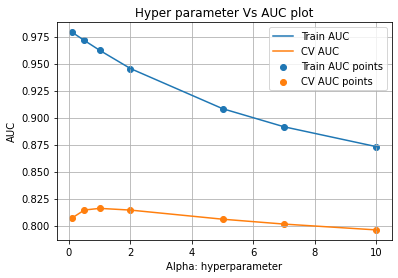

In [37]:
plt.plot(alphas, train_auc, label='Train AUC')
plt.plot(alphas, cv_auc, label='CV AUC')
plt.scatter(alphas, train_auc, label='Train AUC points')
plt.scatter(alphas, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")  
plt.grid()
plt.show()

In [38]:
bestparam=clf.best_params_['alpha']   #extracting the best hyperparameter
print("The best Alpha=",bestparam)
print(results[results['param_alpha'] == bestparam][['mean_train_score','mean_test_score']])

The best Alpha= 1
   mean_train_score  mean_test_score
2          0.962255         0.815903


# Training With Best Parameter

In [39]:
mul_model = MultinomialNB(alpha=bestparam) #Building a Naive Bayes model with the best alpha
mul_model.fit(x_tr,y_train)               #Training the model

MultinomialNB(alpha=1)

In [40]:
acc = mul_model.score(x_te, y_test)
print('Test Accuracy', acc)
y_pred = mul_model.predict(x_te)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print((cm[0,0]+cm[1,1])/np.sum(cm))

Test Accuracy 0.8284027826575785
[[160956  37907]
 [ 30469 169136]]
0.8284027826575785


In [41]:
y_prob = mul_model.predict_proba(x_te)
print(y_prob[:,0])
idx = (y_pred != y_test)
idx = [i for i,j in enumerate(idx) if j]
print(X_test.values.shape)
# print(y_test.values[idx].shape)
miss = pd.DataFrame({'tweet':X_test.values[idx], 'target':y_test.values[idx], 'prob_0': y_prob[:,0][idx] ,'prob_1': y_prob[:,1][idx]})
miss.head()
miss.to_csv('mispredictions.csv')

[1.83892901e-06 3.34220520e-02 2.83413254e-02 ... 4.00730065e-01
 8.62916642e-01 1.75250185e-03]
(398468,)


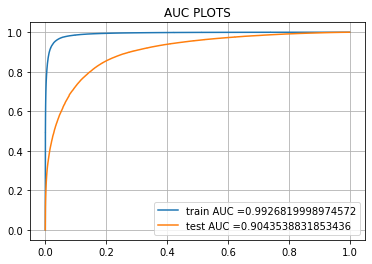

In [42]:
y_train_pred = mul_model.predict_proba(x_tr)[:,1]  #Prediction using the model(log probability of each class)
y_test_pred = mul_model.predict_proba(x_te)[:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)   
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.title("AUC PLOTS")             #Plotting train and test AUC 
plt.grid()
plt.show()

In [43]:
trauc=round(auc(train_fpr, train_tpr),3)
teauc=round(auc(test_fpr, test_tpr),3)
print('Train AUC=',trauc)
print('Test AUC=',teauc)

Train AUC= 0.993
Test AUC= 0.904


In [44]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]      #finding the best threshold 
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:                                 #building a confusion matrix with the best threshold 
            predictions.append(0)
    return predictions

In [45]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
TRCM=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
TECM=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

the maximum value of tpr*(1-fpr) 0.9242285361535734 for threshold 0.479


In [46]:
def CM(x,y):
    labels = ['TN','FP','FN','TP']
    group_counts = ["{0:0.0f}".format(value) for value in x.flatten()]
                    
    labels = [f"{v1}\n{v2}" for v1, v2 in
    zip(labels,group_counts)]
    labels = np.asarray(labels).reshape(2,2)       #Building a design for the confusion matrix
    sns.heatmap(x, annot=labels, fmt='', cmap='BuPu')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(y)
    plt.plot()

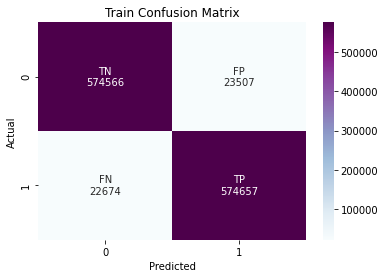

In [47]:
CM(TRCM,'Train Confusion Matrix')

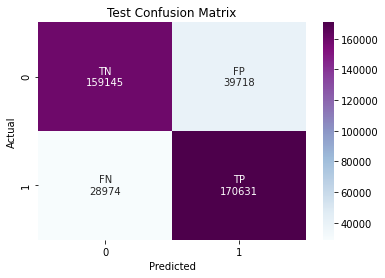

In [48]:
CM(TECM,'Test Confusion Matrix')

# Testing on Pfizer Dataset

In [49]:
df = pd.read_csv('Cleaned_Pfizer_Dataset.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [50]:
df.head()

,tweet
0,text
1,folks say daikon paste could treat cytokine storm
2,world wrong side history year hopefully bigges...
3,russian vaccine create last years
4,facts immutable senator even ethically sturdy ...


In [51]:
covid_tweets=vectorizer.transform(df['tweet'].values)

In [52]:
print(covid_tweets)

  (0, 6181013)	1
  (1, 1212430)	1
  (1, 1225041)	1
  (1, 2080396)	1
  (1, 4666213)	1
  (1, 5356760)	1
  (1, 5938225)	1
  (1, 6542280)	1
  (2, 622427)	1
  (2, 1697173)	1
  (2, 1788931)	1
  (2, 2853829)	1
  (2, 2929423)	1
  (2, 5593431)	1
  (2, 6773397)	1
  (2, 7199208)	1
  (2, 7203850)	1
  (2, 7257933)	1
  (2, 7260723)	1
  (2, 7312908)	1
  (2, 7315018)	1
  (3, 1267329)	1
  (3, 1267776)	1
  (3, 3379231)	1
  (3, 3392860)	1
  :	:
  (8024, 6842105)	1
  (8024, 7054592)	1
  (8025, 1565358)	1
  (8025, 1567199)	1
  (8025, 5422504)	1
  (8025, 5545412)	1
  (8025, 5545890)	1
  (8025, 6193084)	1
  (8025, 6773442)	1
  (8025, 6773466)	1
  (8026, 196236)	1
  (8026, 2760970)	1
  (8026, 3056289)	1
  (8026, 3058712)	1
  (8026, 4453603)	1
  (8026, 5422504)	1
  (8026, 6193084)	1
  (8026, 6193602)	1
  (8026, 6773442)	1
  (8026, 6820757)	1
  (8026, 7192446)	1
  (8027, 129819)	1
  (8027, 3495955)	1
  (8027, 4944646)	1
  (8027, 6773485)	1


In [53]:
prediction = mul_model.predict(covid_tweets)

In [54]:
print(prediction)

[0 0 0 ... 1 1 0]


In [55]:
df['prediction'] = prediction